# DATA SCIENCE SESSIONS VOL. 3
### A Foundational Python Data Science Course
## Session 20: Decision trees regularization and cost complexity prunning

[&larr; Back to course webpage](https://datakolektiv.com/)

Feedback should be send to [goran.milovanovic@datakolektiv.com](mailto:goran.milovanovic@datakolektiv.com). 

These notebooks accompany the DATA SCIENCE SESSIONS VOL. 3 :: A Foundational Python Data Science Course.

![](../img/IntroRDataScience_NonTech-1.jpg)

### Lecturers

[Goran S. Milovanović, PhD, DataKolektiv, Chief Scientist & Owner](https://www.linkedin.com/in/gmilovanovic/)

[Aleksandar Cvetković, PhD, DataKolektiv, Consultant](https://www.linkedin.com/in/alegzndr/)

[Ilija Lazarević, MA, DataKolektiv, Consultant](https://www.linkedin.com/in/ilijalazarevic/)

![](../img/DK_Logo_100.png)

***

In [1]:
### --- Setup - importing the libraries

# - supress those annoying 'Future Warning'
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# - data
import numpy as np
import pandas as pd

# - os
import os

from sklearn.metrics import r2_score, accuracy_score, f1_score, classification_report, confusion_matrix

from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score, GridSearchCV, cross_validate
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.preprocessing import LabelEncoder

# - visualization
import matplotlib.pyplot as plt
import seaborn as sns

# - directory tree
data_dir = os.path.join(os.getcwd(), '_data')

In [2]:
np.random.seed(42)

# Decision Trees Regularization



Previous session was all about how decision trees are created and used in classification and regression problems. We have seen that decision trees very easy overfit to the data, and this is because of the way they are constructed. In practice, this is rarely the best approach and overfitting has to be restricted in some way. If you are thinking about regularisation of some sort, you are on the right track. Similarly to how we regularized simple and generalized linear models, we want to regularize decision trees. After all, overfitting makes our model not being able to generalize to the unseen data. And that makes our model unusable.

Let's refresh our memory with simple classification example that we had in previous session.

In [3]:
df_balls = pd.read_csv(os.path.join(data_dir, 'classification_example.csv'), index_col=0)

In [4]:
df_balls

,num,owner,color,color_label,owner_le
0,0,jake,b,1,1
1,1,jake,r,0,1
2,2,jake,r,0,1
3,3,fin,r,0,0
4,4,fin,b,1,0
5,5,jake,b,1,1
6,6,fin,b,1,0
7,7,lsp,r,0,2
8,8,jake,b,1,1
9,9,lsp,b,1,2


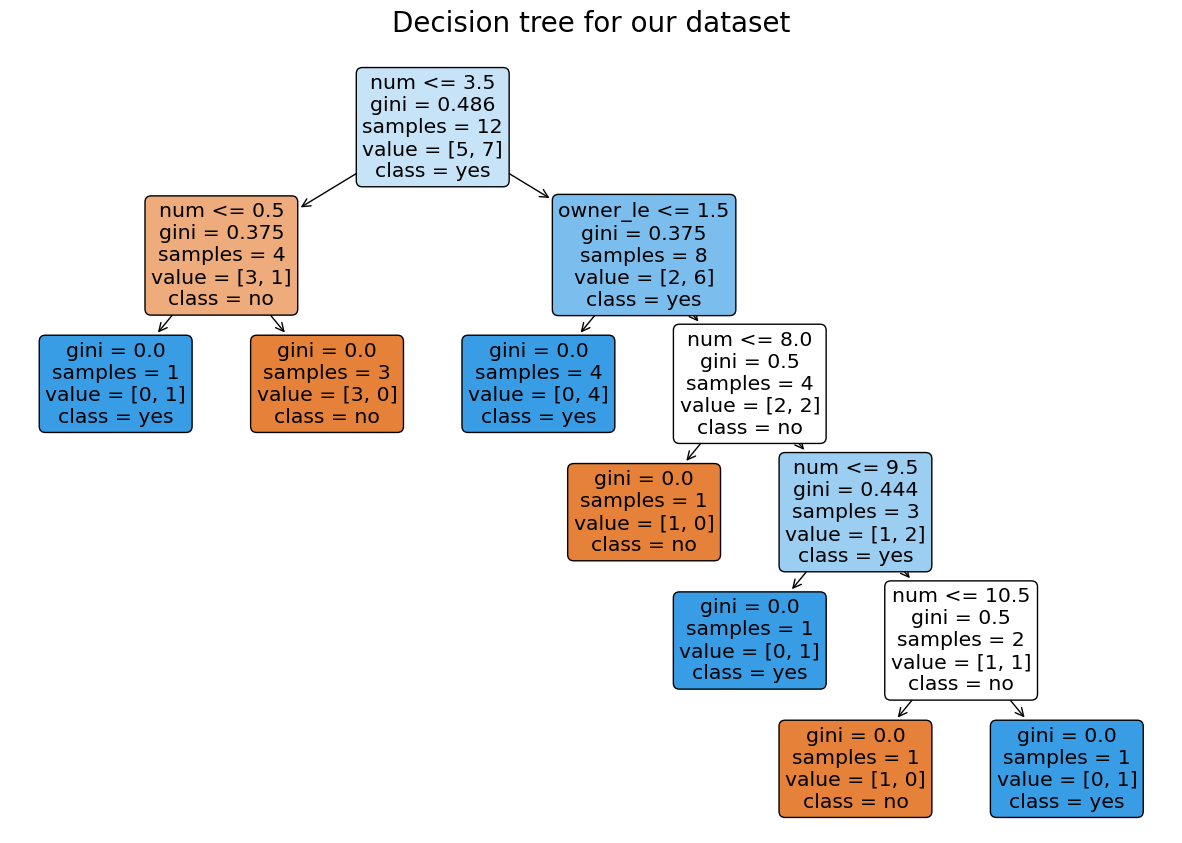

In [5]:
dc = DecisionTreeClassifier(criterion='gini')

dc.fit(df_balls[['owner_le', 'num']], df_balls['color_label'])

# plot the DT
fig = plt.figure(figsize=(15, 10))
_ = tree.plot_tree(dc, 
                   feature_names=dc.feature_names_in_,  
                   class_names=['no', 'yes'],
                   filled=True, 
                   rounded=True)

plt.gca().set_title('Decision tree for our dataset', y=1.03, size=20);

As you can see, leaf nodes are pure in that sense that they consist only observations of the same class. This tree is grown to it's full size and therefore most certainly overfits.

How can we measure this? One way is to have train and test set, and measure the performance of your model on both datasets. Other is to use cross-validation and do the same process many times. This way you get better insight into how your model performs on more than one train/test split.

In [6]:
df_balls

,num,owner,color,color_label,owner_le
0,0,jake,b,1,1
1,1,jake,r,0,1
2,2,jake,r,0,1
3,3,fin,r,0,0
4,4,fin,b,1,0
5,5,jake,b,1,1
6,6,fin,b,1,0
7,7,lsp,r,0,2
8,8,jake,b,1,1
9,9,lsp,b,1,2


In [7]:
X, y = df_balls[['num', 'owner_le']], df_balls['color_label']

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.6, random_state=42, shuffle=True)

In [9]:
dc = DecisionTreeClassifier(criterion='gini')
dc.fit(X_train, y_train)

DecisionTreeClassifier()

In [10]:
dc.predict(X_test)

array([1, 0, 0, 1, 1])

In [11]:
print(classification_report(y_train, dc.predict(X_train)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         3

    accuracy                           1.00         7
   macro avg       1.00      1.00      1.00         7
weighted avg       1.00      1.00      1.00         7



In [12]:
print(classification_report(y_test, dc.predict(X_test)))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.67      0.50      0.57         4

    accuracy                           0.40         5
   macro avg       0.33      0.25      0.29         5
weighted avg       0.53      0.40      0.46         5



Even after looking at these, you can see that train set accuracy is unbelivabely 100% while on test set is only 40%. So, you could use the same approach but with cross-validation, and here is how you could do it:

In [13]:
cross_val_score(DecisionTreeClassifier(criterion='gini'), X, y, cv=5, scoring='accuracy')

array([0.33333333, 0.66666667, 0.5       , 0.5       , 0.5       ])

So these are the accuracies on each fold of cross-validation. This is bad result. And yes, the dataset is small and decision tree easily overfits, but it can overfit just as easy with bigger datasets.

Here is the example on Titanic datset. It is divided in train and test dataset, right from the start. Let's use just train dataset for our example here.

In [14]:
df_titanic_train = pd.read_csv('_data/Titanic_train.csv')

In [15]:
df_titanic_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Let's select few columns for our classification model.

In [16]:
df_titanic_train = df_titanic_train[['Pclass', 'Sex', 'Age', 'Fare', 'Embarked', 'Survived']]

df_titanic_train = df_titanic_train.dropna()

df_titanic_train

,Pclass,Sex,Age,Fare,Embarked,Survived
0,3,male,22.0,7.2500,S,0
1,1,female,38.0,71.2833,C,1
2,3,female,26.0,7.9250,S,1
3,1,female,35.0,53.1000,S,1
4,3,male,35.0,8.0500,S,0
...,...,...,...,...,...,...
885,3,female,39.0,29.1250,Q,0
886,2,male,27.0,13.0000,S,0
887,1,female,19.0,30.0000,S,1
889,1,male,26.0,30.0000,C,1


In [17]:
df_titanic_train['Survived'].value_counts()

0    424
1    288
Name: Survived, dtype: int64

This set is definitely unbalanced, and this will affect some of our metrics.

Let's balance it by dropping some observations from overrepresented class.

In [18]:
df_titanic_train = df_titanic_train.groupby('Survived').apply(lambda x: x.sample(288)).reset_index(drop=True)

In [19]:
df_titanic_train['Survived'].value_counts()

0    288
1    288
Name: Survived, dtype: int64

We also have to encode string/categorical variables.

In [20]:
df_titanic_train.loc[:,  'Sex'] = df_titanic_train['Sex'].apply(lambda x: x == 'female').astype('int32')

le_embarked = LabelEncoder()
df_titanic_train.loc[:, 'Embarked'] = le_embarked.fit_transform(df_titanic_train.loc[:, 'Embarked'])

In [21]:
df_titanic_train

,Pclass,Sex,Age,Fare,Embarked,Survived
0,2,0,27.0,13.0000,2,0
1,3,0,19.0,6.7500,1,0
2,3,0,40.0,27.9000,2,0
3,3,0,26.0,8.6625,2,0
4,3,0,16.0,7.7750,2,0
...,...,...,...,...,...,...
571,1,1,48.0,25.9292,2,1
572,3,1,29.0,15.2458,0,1
573,1,1,18.0,79.6500,2,1
574,3,0,32.0,7.9250,2,1


Now let's construct the tree and try to visualize it.

In [22]:
X, y = df_titanic_train.drop(columns=['Survived']), df_titanic_train['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.8, random_state=42, shuffle=True, stratify=y)

In [23]:
dc = DecisionTreeClassifier(criterion='gini')
dc.fit(X_train, y_train)

DecisionTreeClassifier()

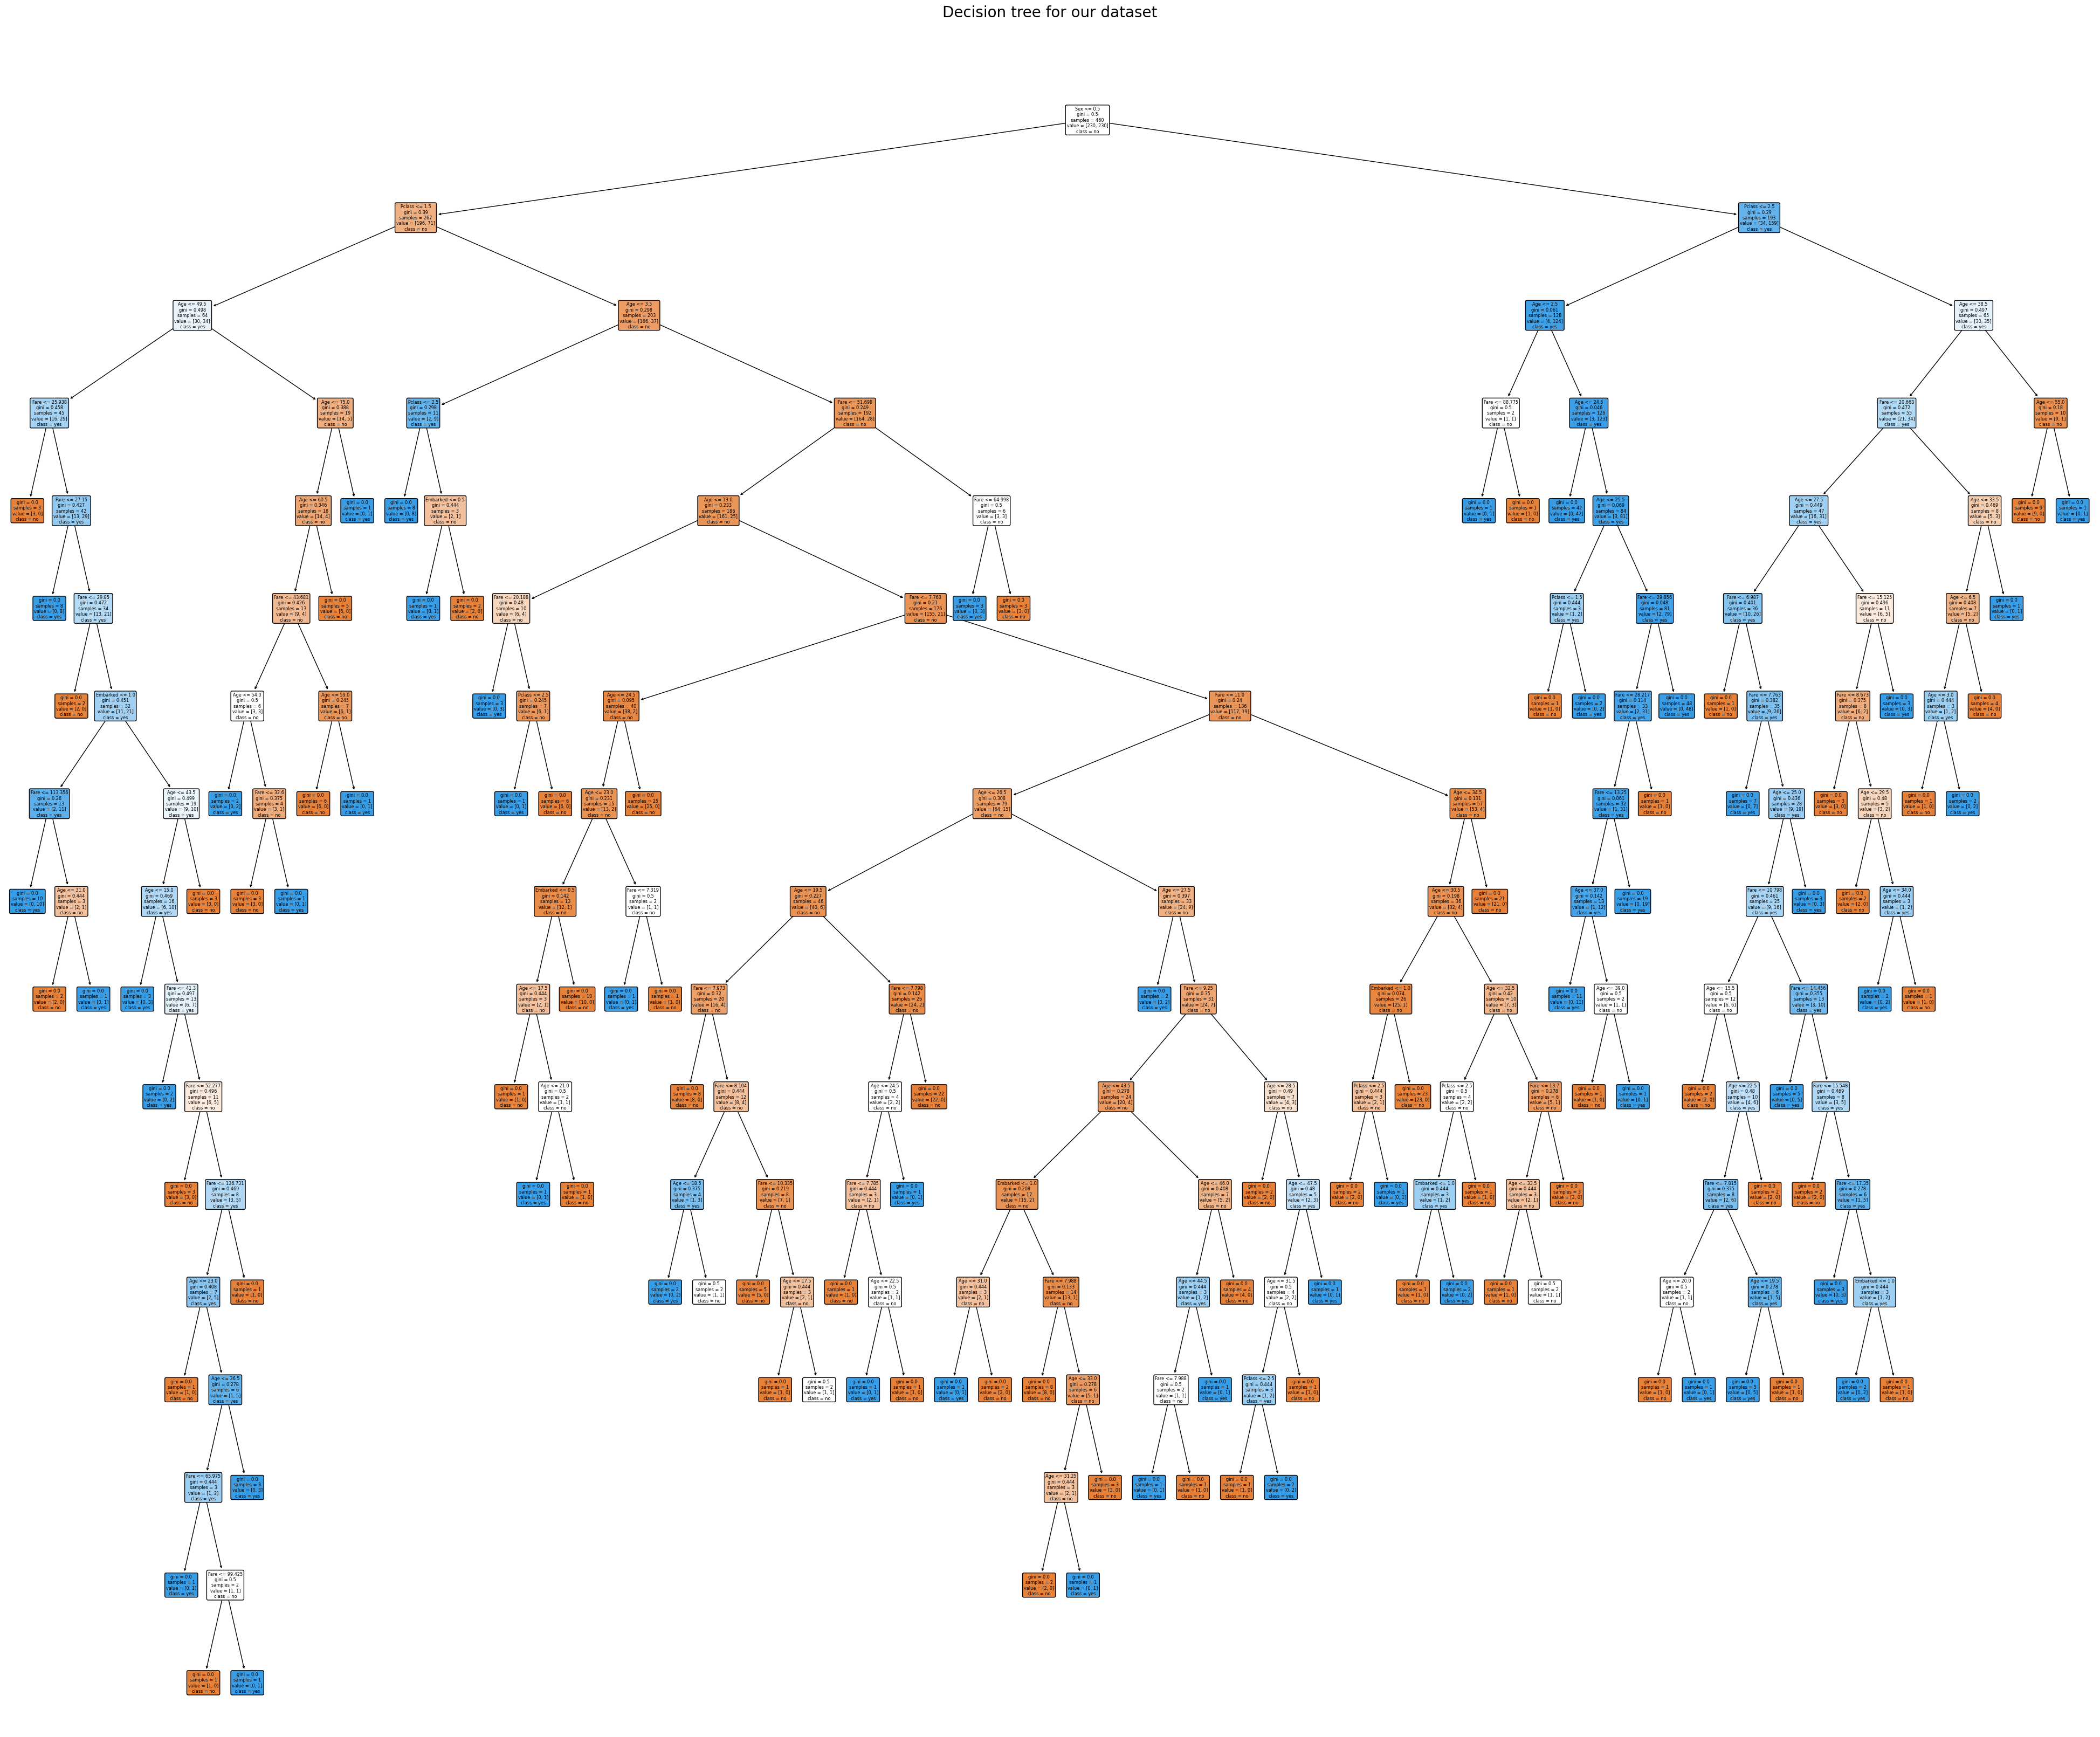

In [24]:
# plot the DT
fig = plt.figure(figsize=(50, 40))
_ = tree.plot_tree(dc, 
                   feature_names=dc.feature_names_in_,  
                   class_names=['no', 'yes'],
                   filled=True, 
                   rounded=True)

plt.gca().set_title('Decision tree for our dataset', y=1.03, size=20);

Does this tree overfit?

In [25]:
print(classification_report(y_train, dc.predict(X_train)))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       230
           1       1.00      0.99      0.99       230

    accuracy                           0.99       460
   macro avg       0.99      0.99      0.99       460
weighted avg       0.99      0.99      0.99       460



In [26]:
print(classification_report(y_test, dc.predict(X_test)))

              precision    recall  f1-score   support

           0       0.74      0.84      0.79        58
           1       0.82      0.71      0.76        58

    accuracy                           0.78       116
   macro avg       0.78      0.78      0.77       116
weighted avg       0.78      0.78      0.77       116



How about we use cross-validation on this dataset as well?

In [27]:
cross_val_score(DecisionTreeClassifier(criterion='gini'),  X_train, y_train, cv=5, scoring='accuracy')

array([0.82608696, 0.76086957, 0.82608696, 0.76086957, 0.73913043])

In [28]:
cross_validate(DecisionTreeClassifier(criterion='gini'), X_train, y_train, scoring='accuracy', cv=5, return_train_score=True)

{'fit_time': array([0.00189996, 0.00160694, 0.00178432, 0.00168037, 0.001683  ]),
 'score_time': array([0.00095153, 0.00087357, 0.00090504, 0.00103307, 0.0007093 ]),
 'test_score': array([0.81521739, 0.75      , 0.83695652, 0.73913043, 0.7173913 ]),
 'train_score': array([0.99728261, 1.        , 0.99184783, 0.99184783, 0.99456522])}

Yes, there is an overfit. Note, decision tree will and should grow as much as it can, until all leaf nodes have observations from the same class. However, this is not shown on the previous chart. Somehow, there is a catch that prevents DecisionTreeClassifier to grow fully, since obviously there is a few nodes that could be split further.

Anyway, how should we counter overfitting?

Astute studens probably noticed `max_depth` argument that we used in DecisionTreeClassifier constructor, in previous session. By using it, we were able to limit the depth of the tree. If that sounds to you like a way of regularizing the decision tree, you are right. There are quite a few approaches you can use to restrict the growth of your tree.

Based on when these approaches are used we can differentiate: **pre-prunning** and **post-pruning** approaches.

## Pre-prunning

As the name suggests, pre-prunning approach deals with overfitting before tree is fully grown. 

Essentially, we set restrictions before we start growing tree. How?

With already mentioned `max_depth` we will describe most used ones:
- `max_depth` - sets a maximum depth of a tree before growing of the tree is started.
- `min_samples_leaf` - sets the number of observations that is required to end up in a leaf node.
- `min_samples_split` - sets a number of observations required in the node before we can split it further. 

How this works in practice?

### max_depth regularization

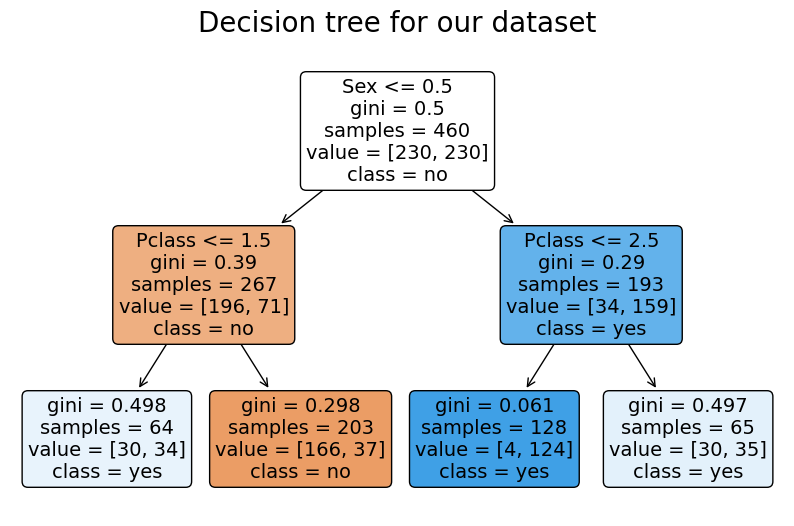

In [29]:
dc = DecisionTreeClassifier(criterion='gini', max_depth=2)
dc.fit(X_train, y_train)

# plot the DT
fig = plt.figure(figsize=(10, 6))
_ = tree.plot_tree(dc, 
                   feature_names=dc.feature_names_in_,  
                   class_names=['no', 'yes'],
                   filled=True, 
                   rounded=True)

plt.gca().set_title('Decision tree for our dataset', y=1.03, size=20);

### min_samples_leaf regularization

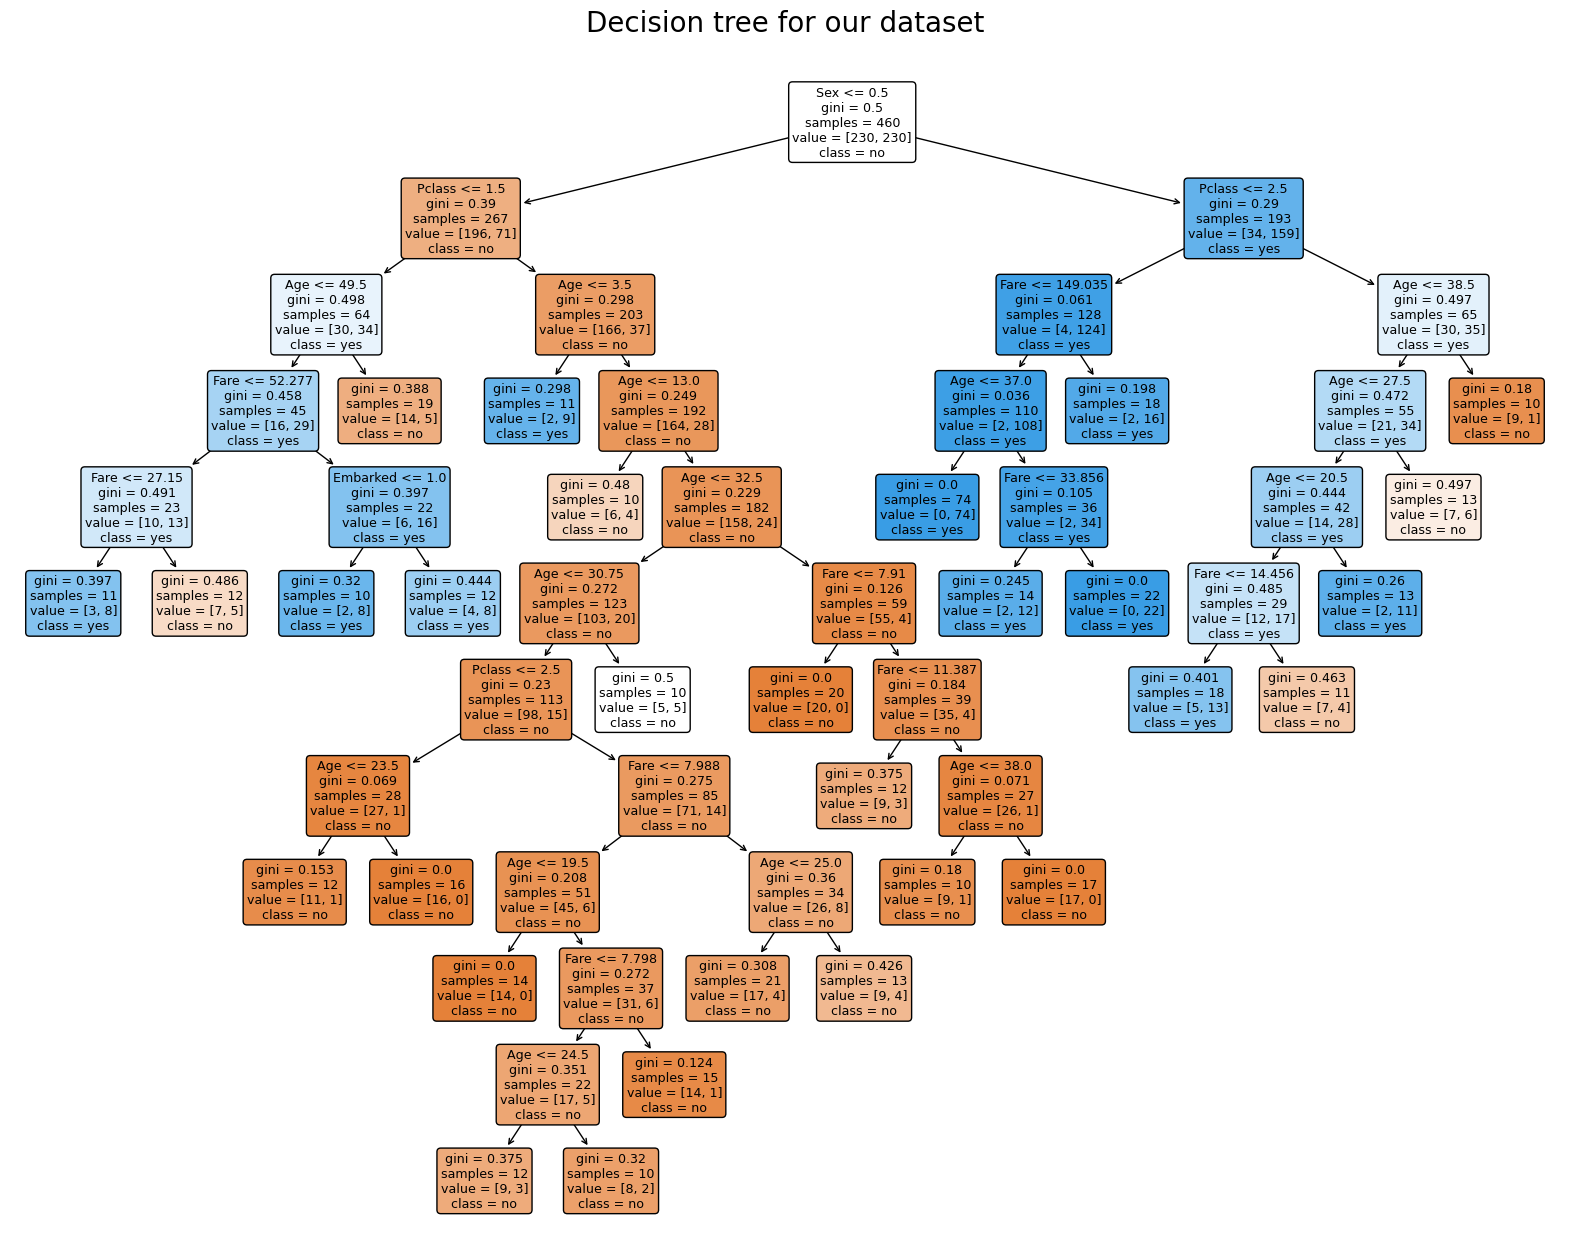

In [30]:
dc = DecisionTreeClassifier(criterion='gini', min_samples_leaf=10)
dc.fit(X_train, y_train)

# plot the DT
fig = plt.figure(figsize=(20, 15))
_ = tree.plot_tree(dc, 
                   feature_names=dc.feature_names_in_,  
                   class_names=['no', 'yes'],
                   filled=True, 
                   rounded=True)

plt.gca().set_title('Decision tree for our dataset', y=1.03, size=20);

### min_samples_split regularization

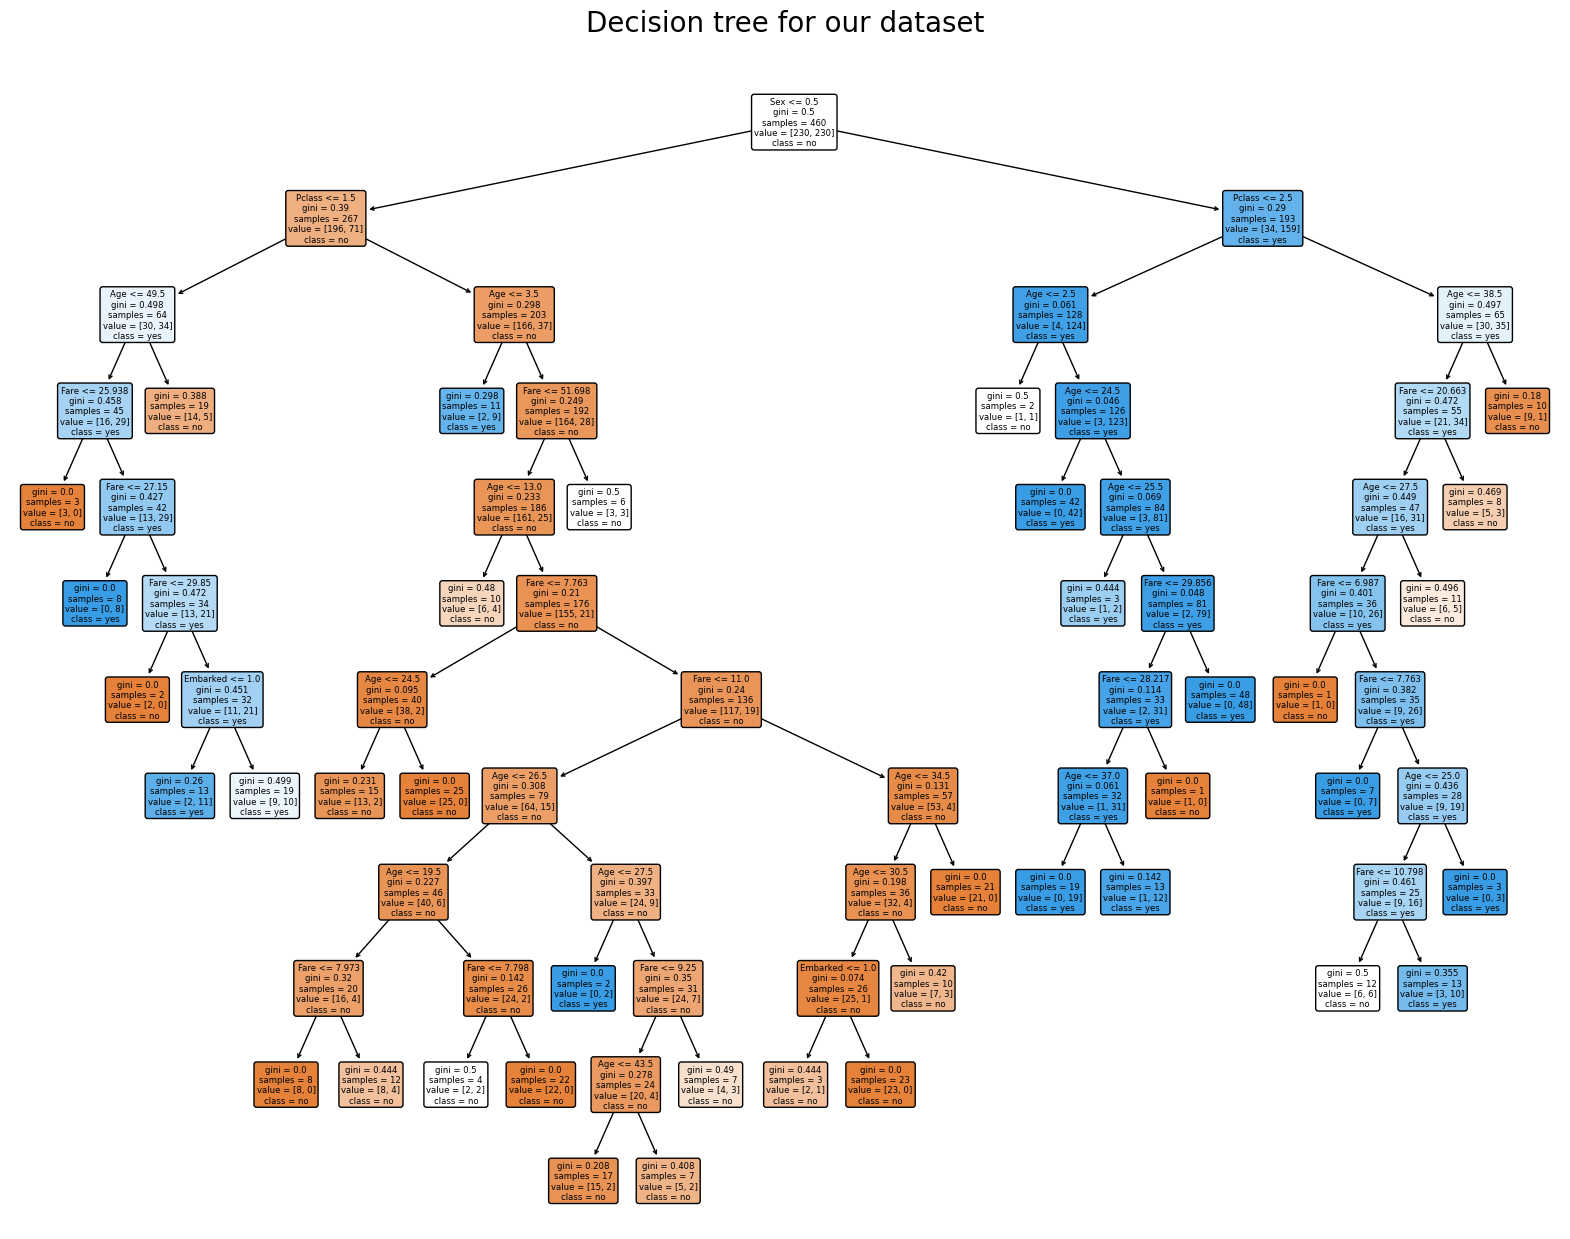

In [31]:
dc = DecisionTreeClassifier(criterion='gini', min_samples_split=20)
dc.fit(X_train, y_train)

# plot the DT
fig = plt.figure(figsize=(20, 15))
_ = tree.plot_tree(dc, 
                   feature_names=dc.feature_names_in_,  
                   class_names=['no', 'yes'],
                   filled=True, 
                   rounded=True)

plt.gca().set_title('Decision tree for our dataset', y=1.03, size=20);

So, how do we choose the right approach? Well... why not use all at the same time, with grid search?

In [32]:
dc = DecisionTreeClassifier(criterion='gini')

param_grid = {
    'max_depth': list(range(4, 10)),
    'min_samples_leaf': list(range(2, 20)),
    'min_samples_split': list(range(2, 20))
}

gs = GridSearchCV(estimator=dc, 
                  param_grid=param_grid, 
                  scoring='accuracy', 
                  cv=5, 
                  n_jobs=-1, 
                  return_train_score=True, 
                  refit=True)

gs.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'max_depth': [4, 5, 6, 7, 8, 9],
                         'min_samples_leaf': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                              12, 13, 14, 15, 16, 17, 18, 19],
                         'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                               12, 13, 14, 15, 16, 17, 18,
                                               19]},
             return_train_score=True, scoring='accuracy')

Now that the grid search searched for best parameters combination, here are the best ones:

In [33]:
gs.best_params_

{'max_depth': 5, 'min_samples_leaf': 11, 'min_samples_split': 2}

And the best accuracy score on test folds is:

In [34]:
gs.best_score_

0.8217391304347826

We can use cross-validation results and create Pandas DataFrame:

In [35]:
df_gs_results = pd.DataFrame(gs.cv_results_)

df_gs_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.006853,0.002565,0.002281,0.000881,4,2,2,"{'max_depth': 4, 'min_samples_leaf': 2, 'min_s...",0.847826,0.76087,...,0.773913,0.051168,1875,0.836957,0.842391,0.834239,0.836957,0.86413,0.842935,0.010924
1,0.005960,0.003494,0.001607,0.000408,4,2,3,"{'max_depth': 4, 'min_samples_leaf': 2, 'min_s...",0.847826,0.76087,...,0.763043,0.046828,1935,0.836957,0.842391,0.842391,0.836957,0.86413,0.844565,0.010080
2,0.004837,0.000816,0.001529,0.000332,4,2,4,"{'max_depth': 4, 'min_samples_leaf': 2, 'min_s...",0.847826,0.76087,...,0.763043,0.046828,1935,0.836957,0.842391,0.842391,0.836957,0.86413,0.844565,0.010080
3,0.002774,0.000694,0.001333,0.000075,4,2,5,"{'max_depth': 4, 'min_samples_leaf': 2, 'min_s...",0.847826,0.76087,...,0.773913,0.051168,1875,0.836957,0.842391,0.834239,0.836957,0.86413,0.842935,0.010924
4,0.002772,0.000476,0.001513,0.000196,4,2,6,"{'max_depth': 4, 'min_samples_leaf': 2, 'min_s...",0.847826,0.76087,...,0.773913,0.051168,1875,0.836957,0.842391,0.834239,0.836957,0.86413,0.842935,0.010924


Best score is where `rank_test_score = 1`.

In [36]:
df_gs_results[df_gs_results['rank_test_score'] == 1].T

,486,489,491,492,493,495,500,503,810,811,...,1786,1788,1789,1792,1793,1795,1796,1797,1798,1799
mean_fit_time,0.002304,0.002136,0.001937,0.002048,0.002111,0.0021,0.002094,0.002111,0.002227,0.002172,...,0.00226,0.002166,0.002431,0.002151,0.002845,0.002212,0.002123,0.002107,0.002066,0.002103
std_fit_time,0.000043,0.000078,0.000033,0.000068,0.000062,0.000077,0.000065,0.000075,0.000102,0.000087,...,0.000124,0.000097,0.000723,0.000019,0.000946,0.00013,0.00005,0.000092,0.000059,0.000053
mean_score_time,0.001487,0.001321,0.001243,0.001363,0.001291,0.001311,0.00135,0.001333,0.001417,0.001377,...,0.001343,0.00144,0.002696,0.001382,0.002537,0.001362,0.001323,0.001352,0.001388,0.001321
std_score_time,0.00004,0.000108,0.000055,0.000096,0.000042,0.000039,0.000047,0.000056,0.000033,0.000086,...,0.00003,0.000109,0.002098,0.00006,0.002238,0.000042,0.000023,0.000059,0.000078,0.000058
param_max_depth,5,5,5,5,5,5,5,5,6,6,...,9,9,9,9,9,9,9,9,9,9
param_min_samples_leaf,11,11,11,11,11,11,11,11,11,11,...,11,11,11,11,11,11,11,11,11,11
param_min_samples_split,2,5,7,8,9,11,16,19,2,3,...,6,8,9,12,13,15,16,17,18,19
params,"{'max_depth': 5, 'min_samples_leaf': 11, 'min_...","{'max_depth': 5, 'min_samples_leaf': 11, 'min_...","{'max_depth': 5, 'min_samples_leaf': 11, 'min_...","{'max_depth': 5, 'min_samples_leaf': 11, 'min_...","{'max_depth': 5, 'min_samples_leaf': 11, 'min_...","{'max_depth': 5, 'min_samples_leaf': 11, 'min_...","{'max_depth': 5, 'min_samples_leaf': 11, 'min_...","{'max_depth': 5, 'min_samples_leaf': 11, 'min_...","{'max_depth': 6, 'min_samples_leaf': 11, 'min_...","{'max_depth': 6, 'min_samples_leaf': 11, 'min_...",...,"{'max_depth': 9, 'min_samples_leaf': 11, 'min_...","{'max_depth': 9, 'min_samples_leaf': 11, 'min_...","{'max_depth': 9, 'min_samples_leaf': 11, 'min_...","{'max_depth': 9, 'min_samples_leaf': 11, 'min_...","{'max_depth': 9, 'min_samples_leaf': 11, 'min_...","{'max_depth': 9, 'min_samples_leaf': 11, 'min_...","{'max_depth': 9, 'min_samples_leaf': 11, 'min_...","{'max_depth': 9, 'min_samples_leaf': 11, 'min_...","{'max_depth': 9, 'min_samples_leaf': 11, 'min_...","{'max_depth': 9, 'min_samples_leaf': 11, 'min_..."
split0_test_score,0.847826,0.847826,0.847826,0.847826,0.847826,0.847826,0.847826,0.847826,0.847826,0.847826,...,0.847826,0.847826,0.847826,0.847826,0.847826,0.847826,0.847826,0.847826,0.847826,0.847826
split1_test_score,0.858696,0.858696,0.858696,0.858696,0.858696,0.858696,0.858696,0.858696,0.858696,0.858696,...,0.858696,0.858696,0.858696,0.858696,0.858696,0.858696,0.858696,0.858696,0.858696,0.858696


How does this tree looks like?

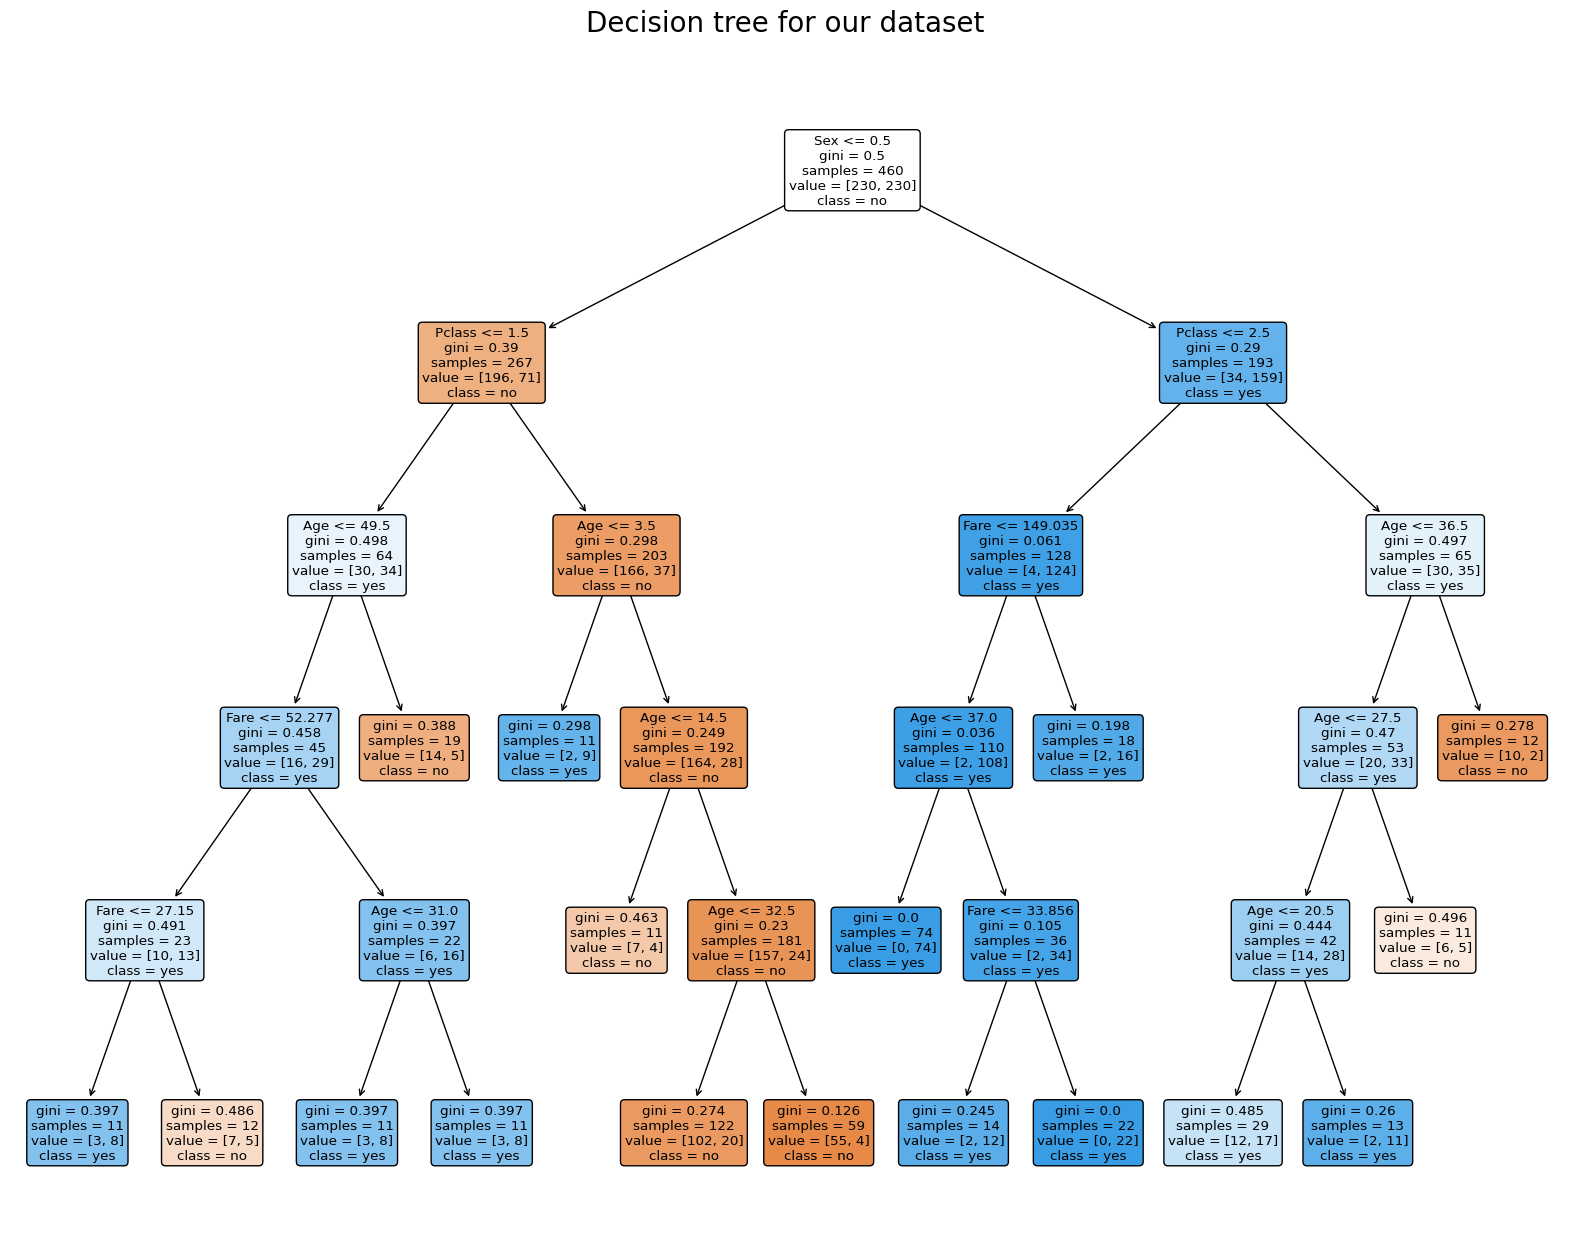

In [37]:
dc = gs.best_estimator_
dc.fit(X_train, y_train)

# plot the DT
fig = plt.figure(figsize=(20, 15))
_ = tree.plot_tree(dc, 
                   feature_names=dc.feature_names_in_,  
                   class_names=['no', 'yes'],
                   filled=True, 
                   rounded=True)

plt.gca().set_title('Decision tree for our dataset', y=1.03, size=20);

And here is the classification report on test dataset.

In [38]:
print(classification_report(y_test, gs.best_estimator_.predict(X_test)))

              precision    recall  f1-score   support

           0       0.73      0.81      0.77        58
           1       0.79      0.71      0.75        58

    accuracy                           0.76       116
   macro avg       0.76      0.76      0.76       116
weighted avg       0.76      0.76      0.76       116



This accuracy score is lower than the one from grid seach!? Something is wrong! 

No, it is not. This test set is the one that was sampled out fromt he original set, and grid search performed cross-validation on what was left after it. 

So these two test scores are on different 'test' sets.

You will stumble across different ways of calling these sets. One part of community splits datasets on so called train and test sets, while others make distinction between different test sets, and calls them validation and test set.

You can be explicit about it and use the 'train' and 'validation' sets when you are talking about the folds in cross-validation, while using 'test' set as the unseen part of the data that is used for final model evaluation.

Again, astute eyes will see that once we are finished with grid search and we have optimal set of model hyperparameters, our train score is lowered but the test score has increased. Does this sound familiar? Have we talked about bias-variance tradeoff? How can we show this in our example?

Let's use one train/test split. Obviously, we want to see how regularization affects bias and variance, so we will for the sake of the example use just one parameter values for regularization purpose. Let's use `min_samples_split`. Having 2 parameter values would require to plot bias and variance in 3D, while using more than two parameters would make visualization impossible. At least the way we are going to do it in next cells.

In [39]:
a, b = 2, 60

cv_train_scores = np.zeros(shape=(b-a,))
cv_test_scores = np.zeros(shape=(b-a,))

msl_range = range(a, b)

for j, ft in enumerate(msl_range):
    dc = DecisionTreeClassifier(criterion='gini', min_samples_split=ft)
    dc.fit(X_train, y_train)
    cv_train_scores[j] = accuracy_score(y_train, dc.predict(X_train))
    cv_test_scores[j] = accuracy_score(y_test, dc.predict(X_test))


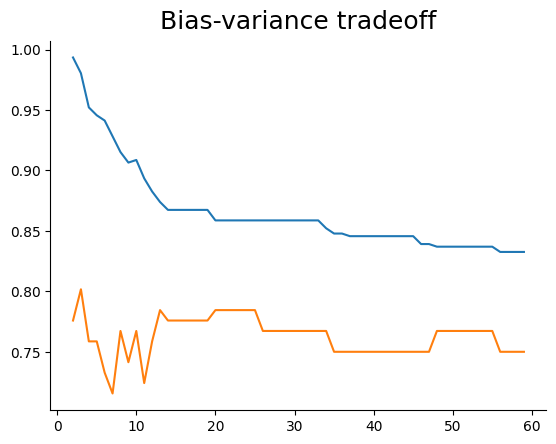

In [40]:
sns.lineplot(x=list(msl_range), y=cv_train_scores)
sns.lineplot(x=list(msl_range), y=cv_test_scores)
sns.despine()
plt.title('Bias-variance tradeoff', size=18, y=1.01);

You can see how accuracy score on train set lowers as we increase regularization through increasing `min_samples_split` hyperparameter. On the other hand, test score keeps increasing until one point, and then it also gets smaller as we keep increasing regularization. So, as we did with previous types of models, we have to find this spot i.e. combination of hyperparameters that make model generalize to unseen data, that is, to have decent score on test dataset.

## Post-prunning

Second approach that you can use in regularizing your decision tree is to let it grow in full size, and then perform regularization called *pruning*. 

What pruning does is that it tries to find a way to remove subtrees and in esence make tree smaller. You can also look at this as reducing the number of leaves.

There are multiple ways of approaching the process of post-prunning. We will describe *minimal cost-complexity pruning* here. There is the implementation of this specific kind of post-pruning in sklearn, so this will be handy to show how it is done.

The theory behing pruning is verbose, with all the theorems and proofs and going into details would just put a lot of noise for you to get the general idea about how it is performed. However, we certainly have to introduce some notation before trying to describe it, even on a general level.

So, you remember how we introduced a measures based on which we decided how to perform splits when growing a tree. These were: 
- `entropy` and `gini` for classification, or 
- `sse` for regression type of problems.

These measures we defined for each node in a tree. Even leaves. Now, we similarly want to introduce this measure for whole tree. This is defined as $R(T)$, where *T* is a tree that we have grown.


If we are talking about classification tree $R(T)$ is overall tree *entropy*, *gini impurity*. If we are having regression tree, then $R(T)$ will be an overall *sse* of the tree. How do we define it? If the measure we used to grow the tree is represented as $m(t)$ where $t$ is a tree node, and $p(t)$ is a proportion of observations ended up in specific node, then:

$$ R(t) = m(t)*p(t).$$

This is just for any provisional tree node. However, this measure that we used, defined for the whole tree, defined as $R(T)$ would be:

$$ R(T) = \sum_{t\in \tilde{T}}^{}{m(t)*p(t)} = \sum_{t\in\tilde{T}}{R(t)},$$

where $\tilde{T}$ is the set of all leaf nodes in the tree.

So, in essence we are going through all leaves in the tree and summming all measures of 'uncertainty' proportionally to the number of observations that ended up in that leaf node.

By now it is evident that growing the tree means increasing number of leaves, and that means decreasing tree uncertainty, also known as overfitting. How can we approach the regularization process now? 

Well, we can introduce penalty based on the number of leaves. So tree that has many leaves will have huge penalty. So, instead of previous definition of whole tree uncertainty, we redefine it with this penalty:

$$ R_{\alpha}(T) = \sum_{t\in\tilde{T}}{R(t)} + \alpha|\tilde{T}| = R(T) + \alpha|\tilde{T}|.$$

Here $\alpha$ is called *complexity parameter*. It should be obvious that when we increase $\alpha$ we increse whole tree uncertainty based on the number of leaves. This way we say that even though larger tree is better, it should not be very large in the end. The larger the $\alpha$ the smaller the tree gets after prunning. The right question would be, what is the right value of complexity parameter. And this is something we will try to find out later.

One important thing to consider is that even we defined $R(T)$ for whole tree, we can most certainly define it for any subtree as well. What constitutes a subtree? Well, pick any internal node in a tree and take all nodes that grow from it along with leaves. This is a subtree, and this subree can also have it's uncertainty measure defined as:

$$ R_{\alpha}(T_t) = R(T_t) + \alpha|\tilde{T}_t|. $$

So how the prunning is performed? Well, we prune tree branch by branch. And for each prunning step we have specific value of $\alpha$. At first $\alpha$ is 0, and we keep increasing it. But for how long it is increased? Let's get back to the theory.

We have defined uncertainty for one tree node as $R(t)$, but we need to add penalty to this one as well. Here how each node can be penalized:

$$ R_{\alpha}(t) = R(t) + \alpha. $$


Now, imagine you are able to take any internal tree node and calculate whole uncertainty of it's subtree if it was further split, or just it's uncertainty if it was not split i.e. if it was a leaf. What sould be clear now is that no matter whether you are looking at the tree or any of its subtrees, growing it reduces its whole uncertainty. So, from here we have that:

$$ R(t) > R(T_t).$$



However with increasing penalized versions of these measures, i.e., increasing $\alpha$ value, at some point:

$$ R_{\alpha}(t) = R_{\alpha}(T_t).$$

This can be rewritten as:

$$ R(t) + \alpha = R(T_t) + \alpha|\tilde{T}_t|. $$

This can be solved for $\alpha$ and we get:

$$ \alpha = \frac{R(t) - R(T_t)}{|\tilde{T}_t| - 1} $$ 

From this equation we have a way to get list of $\alpha$ values. We traverse all internal nodes of a tree, and get the value of complexity parameter at which value this node's penalty makes growing its subtree useless.

How about an example for this? Let's use our toy example for easier prunning process.

In [41]:
df_balls

,num,owner,color,color_label,owner_le
0,0,jake,b,1,1
1,1,jake,r,0,1
2,2,jake,r,0,1
3,3,fin,r,0,0
4,4,fin,b,1,0
5,5,jake,b,1,1
6,6,fin,b,1,0
7,7,lsp,r,0,2
8,8,jake,b,1,1
9,9,lsp,b,1,2


Remember how we let this tree grow to its full size.

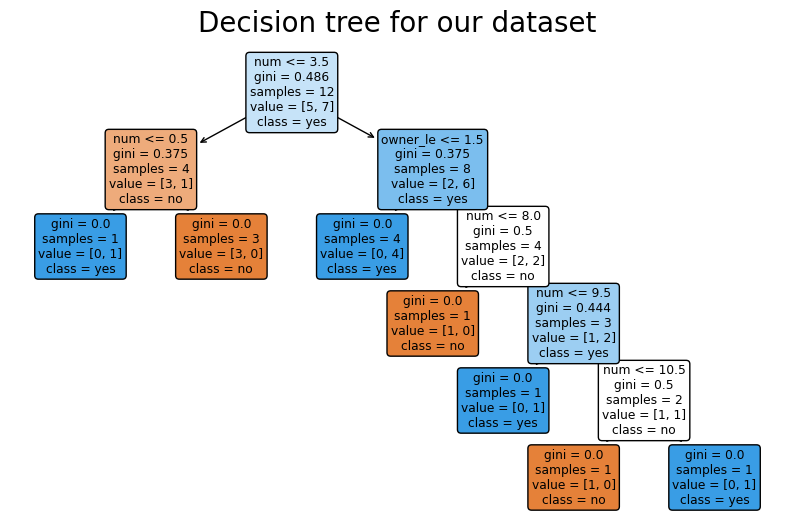

In [42]:
dc = DecisionTreeClassifier(criterion='gini')

dc.fit(df_balls[['owner_le', 'num']], df_balls['color_label'])

# plot the DT
fig = plt.figure(figsize=(10, 6))
_ = tree.plot_tree(dc, 
                   feature_names=dc.feature_names_in_,  
                   class_names=['no', 'yes'],
                   filled=True, 
                   rounded=True)

plt.gca().set_title('Decision tree for our dataset', y=1.03, size=20);

Let's pick rightmost internal node, with `num <= 10.5` split feature/value, and get $\alpha$ value for it.

Its $R(t)$ is:

In [43]:
Rt = .5 * 2/12

and its $R(T_t)$ is:

In [44]:
RTt = 0

So $\alpha_1$ would be:

In [45]:
alpha_1 = (Rt - RTt) / (2 - 1)

In [46]:
alpha_1

0.08333333333333333

How does this list of cost complexity parameters looks like?

In [47]:
dc.cost_complexity_pruning_path(df_balls[['owner_le', 'num']], df_balls['color_label'])

{'ccp_alphas': array([0.        , 0.05555556, 0.08333333, 0.11805556]),
 'impurities': array([0.        , 0.16666667, 0.25      , 0.48611111])}

Let's use Titanic dataset to see how cost complexity prunning looks like on it.

In [54]:
X, y = df_titanic_train.drop(columns=['Survived']), df_titanic_train['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.8, random_state=42, shuffle=True)

In [55]:
dc = DecisionTreeClassifier(criterion='gini')

dc.fit(X_train, y_train)

DecisionTreeClassifier()

In [56]:
ccp_alphas, impurities = dc.cost_complexity_pruning_path(X_train, y_train).values()

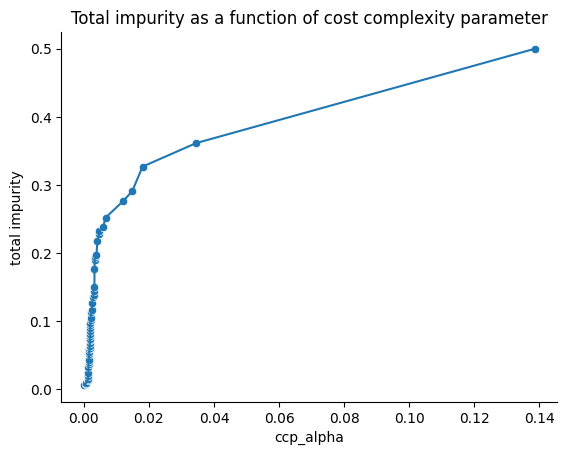

In [57]:
sns.lineplot(x=ccp_alphas, y=impurities)
sns.scatterplot(x=ccp_alphas, y=impurities)
sns.despine()
plt.xlabel('ccp_alpha')
plt.ylabel('total impurity')
plt.title('Total impurity as a function of cost complexity parameter');

And now let's see how each `ccp_alpha` value affects model accuracy on both training and test sets. We will also see how `cpp_alpha` affects tree depth and total number of nodes in a tree.

In [72]:
train_accuracies = np.zeros(shape=len(ccp_alphas))
nodes_number = np.zeros(shape=len(ccp_alphas))
tree_depth = np.zeros(shape=len(ccp_alphas))
test_accuracies = np.zeros(shape=len(ccp_alphas))

for i, alpha in enumerate(ccp_alphas):
    # define a tree classifier
    dc = DecisionTreeClassifier(criterion='gini', ccp_alpha=alpha)
    # train a model i.e. build a tree
    dc.fit(X_train, y_train)

    nodes_number[i] = dc.tree_.node_count
    tree_depth[i] = dc.tree_.max_depth
    # get accuracies on train and test sets
    
    train_accuracies[i] = accuracy_score(y_train, dc.predict(X_train))
    test_accuracies[i] = accuracy_score(y_test, dc.predict(X_test))

Let's plot these arrays as a function of `cpp_alpha` values, each in separate chart.

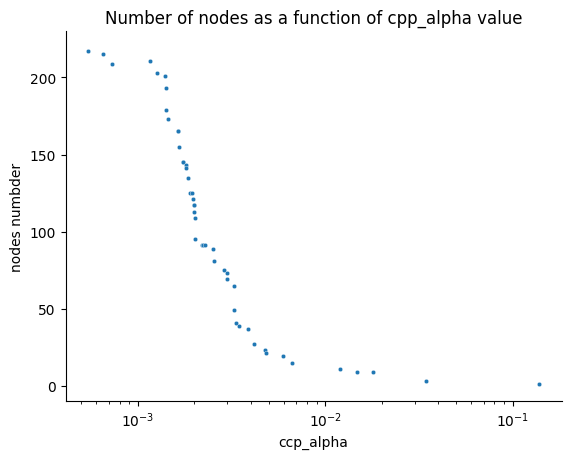

In [73]:
sns.scatterplot(x=ccp_alphas, y=nodes_number, s=10)
sns.despine()
plt.xscale('log')
plt.xlabel('ccp_alpha')
plt.ylabel('nodes numbder')
plt.title('Number of nodes as a function of cpp_alpha value');


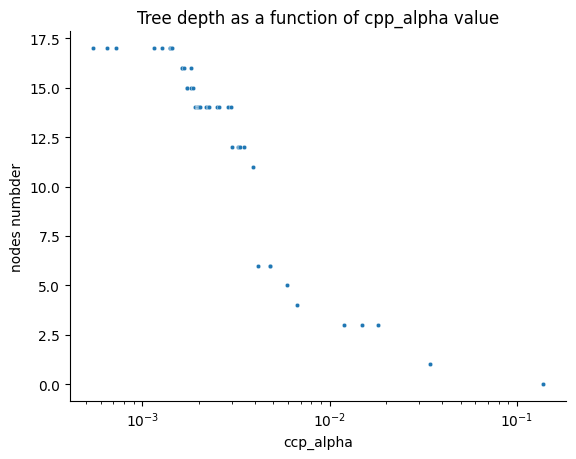

In [74]:
sns.scatterplot(x=ccp_alphas, y=tree_depth, s=10)
sns.despine()
plt.xscale('log')
plt.xlabel('ccp_alpha')
plt.ylabel('nodes numbder')
plt.title('Tree depth as a function of cpp_alpha value');


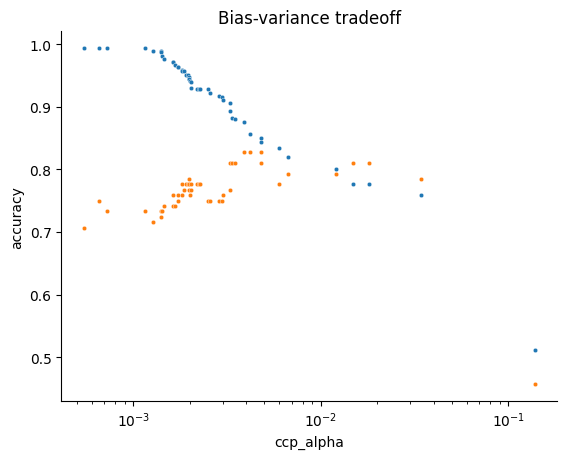

In [75]:
sns.scatterplot(x=ccp_alphas, y=train_accuracies, s=10)
sns.scatterplot(x=ccp_alphas, y=test_accuracies, s=10)
sns.despine()
plt.xscale('log')
plt.xlabel('ccp_alpha')
plt.ylabel('accuracy')
plt.title('Bias-variance tradeoff');


Cross-validating for each `cpp_alpha` is a next step to be able to find the best value for your dataset. However, there is no implementation for this in `sklearn` so we won't go into details now. However, you can think about how this can be achieved. Can we just iterate through predefined range of `cpp_alpha` values?

Developing a regression tree is pretty much the same, except `criterion` now works with continuous (target) variable. Remember to set correct `criterion` though. There is more than the one we mentioned in the previous session. What are the options, and why and when should you use them?

### Further Reading

- [Training, validation, and test data sets](https://en.wikipedia.org/wiki/Training,_validation,_and_test_data_sets)
- [What is the Difference Between Test and Validation Datasets?](https://machinelearningmastery.com/difference-test-validation-datasets/)


***

DataKolektiv, 2022/23.

[hello@datakolektiv.com](mailto:goran.milovanovic@datakolektiv.com)

![](../img/DK_Logo_100.png)

<font size=1>License: [GPLv3](https://www.gnu.org/licenses/gpl-3.0.txt) This Notebook is free software: you can redistribute it and/or modify it under the terms of the GNU General Public License as published by the Free Software Foundation, either version 3 of the License, or (at your option) any later version. This Notebook is distributed in the hope that it will be useful, but WITHOUT ANY WARRANTY; without even the implied warranty of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the GNU General Public License for more details. You should have received a copy of the GNU General Public License along with this Notebook. If not, see http://www.gnu.org/licenses/.</font>